### Load Packages

In [1]:
# primary EDA code
import pandas as pd
import numpy as np
import os

# packages for plots
import matplotlib.pyplot as plt
import seaborn as sns

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# packages for cross-validation
from sklearn.model_selection import StratifiedKFold

### Load Data & Filter NA/ Duplicate Records

In [2]:
# Read files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
def data_import(folder_path, stock_list, signal_type = "buy", number_of_days = 3):
    df_gp = pd.DataFrame()
    print()
    print("Loading", signal_type, "singal data:")
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
          
            # Stock ID is assume to be 4 digits
            pos = max(filename.find('S'), filename.find('B'))
            if pos == -1:
              pos = 45
            stock = str(filename[0:pos]).replace('1','')
            
            print(stock, " ", end = '')
            try:
                temp_df = pd.read_csv(os.path.join(folder_path, filename), delimiter= '\s+', header = None)
                
                # Number of Days Adjustment
                if number_of_days == 9:
                  temp_df = pd.concat([temp_df.iloc[:, 0:41], temp_df.iloc[:, 118:159], temp_df.iloc[:, 236:277], temp_df.iloc[:, 354]],axis=1)
                  
                # Cut first 20 Records
                temp_df = temp_df.iloc[21:,:]
                temp_df = temp_df.reset_index(drop=True)
                
                # Buy/Sell Distinguished
                temp_df.rename(columns={123:'rtn'}, inplace=True)
                if signal_type == "buy":
                  temp_df = pd.concat([pd.Series([1] * temp_df.shape[0], name = 'signal_type'), temp_df], axis=1)
                else:
                  temp_df = pd.concat([pd.Series([0] * temp_df.shape[0], name = 'signal_type'), temp_df], axis=1)
                  temp_df['rtn'] = -temp_df['rtn']
                  
                # Add stock name
                if stock not in stock_list:
                  stock_list.append(stock)
                temp_df = pd.concat([pd.Series([stock_list.index(stock)] * temp_df.shape[0], name = 'stock_name'), temp_df], axis=1)
                
                # Merge into the Output Database
                df_gp = pd.concat([df_gp, temp_df])
                continue
                
            except:
                print('The following file cannot be read: ' + folder_path + filename)
        else:
            continue
    
    # Set all columns to numerics
    for col in df_gp.columns:
      if col != 'stock_name':
        df_gp[col] = pd.to_numeric(df_gp[col],errors='coerce')
    
    # Rename the columns 
    osc_headers = []
    stk_headers = []
    macd_headers = []
    for i in range(41):
        osc_headers.append('osc' + str(i))
        stk_headers.append('stk' + str(i))
        macd_headers.append('macd' + str(i))
    df_gp.columns = ['stock_name'] + ['signal_type'] + osc_headers + stk_headers + macd_headers + ['rtn']
    
    # Reset index
    df_gp = df_gp.reset_index(drop=True)

    return df_gp, stock_list

In [59]:
stock_list = []

# Import Buy & Sell Data
#df_buy9_gp, stock_list = data_import('/content/gdrive/My Drive/capstone/data/9days/', stock_list, signal_type = "buy", number_of_days = 9)
print()
df_buy_gp, stock_list = data_import('/content/gdrive/My Drive/capstone/data/buy/', stock_list, signal_type = "buy")
print()
df_sell_gp, stock_list = data_import('/content/gdrive/My Drive/capstone/data/sell/', stock_list, signal_type = "sell")

#df_combined = df_buy_gp
#df_combined = pd.concat([df_buy9_gp, df_buy_gp, df_sell_gp])
df_combined = pd.concat([df_buy_gp, df_sell_gp])

# Drop Duplicated Records
len_before = df_combined.shape[0]
df_combined = df_combined.drop_duplicates(subset = df_combined.columns[1:])
print()
print()
print("Duplicates dropped:", len_before - df_combined.shape[0])

# Drop Records with NaN
len_before = df_combined.shape[0]
df_combined = df_combined.dropna()
print()
print("Record(s) w/ NaN dropped:", len_before - df_combined.shape[0])
print()

# Only model OSC < 3 or up 
len_before = df_combined.shape[0]
df_combined = df_combined[(df_combined.osc0 < -0.5) | (df_combined.osc0 > 0.5)]
print("Small osc values dropped:", len_before - df_combined.shape[0])
print()

# Reset Index
df_combined = df_combined.reset_index(drop=True)

print("Remained Records:", df_combined.shape[0])
print()

# Check the balance of df_gp
print('Positive returns:', round(np.sum(df_combined.rtn > 0)/len(df_combined.rtn) * 100, 2), '%')
print('Zero returns:', round(np.sum(df_combined.rtn == 0)/len(df_combined.rtn) * 100, 2), '%')
print('Negative returns:', round(np.sum(df_combined.rtn < 0)/len(df_combined.rtn) * 100, 2), '%')

# Check stock movement
print()
print('Avg Stock Movement %', np.mean(df_combined.rtn))
print('Max Stock Movement %', np.max(df_combined.rtn))
print('Min Stock Movement %', np.min(df_combined.rtn))



Loading buy singal data:
adbe  ions  ssys  ati  itub  alny  pxd  ufs  bac  uri  clf  gs  jnpr  crm  mas  crus  pru  bidu  fslr  csiq  jec  db  acad  amd  cenx  teck  meli  

Loading sell singal data:
csiq  fslr  bidu  lvs  uri  mas  pxd  crm  crus  pru  meli  cenx  ufs  acad  amd  db  teck  alny  itub  ati  adsk  ssys  ions  adbe  gs  clf  bac  

Duplicates dropped: 3446

Record(s) w/ NaN dropped: 13

Small osc values dropped: 70375

Remained Records: 133495

Positive returns: 48.83 %
Zero returns: 3.33 %
Negative returns: 47.85 %

Avg Stock Movement % 0.040288250496272805
Max Stock Movement % 77.43
Min Stock Movement % -440.0


0.40909609461155266
2.221694063408715
0.555557668175077


[Text(0, 0.5, 'Count of Signals'), Text(0.5, 0, 'Investement Return')]

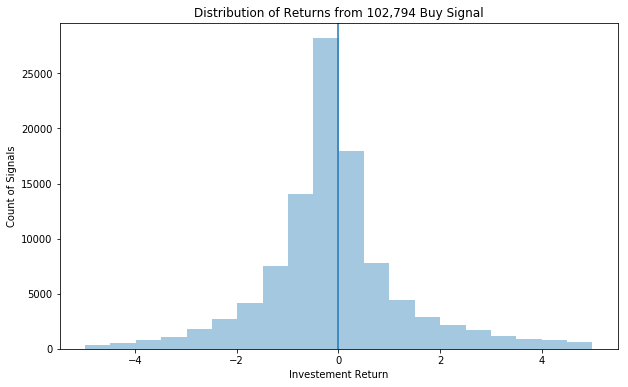

In [95]:
plt.figure(figsize=(10, 6))
plot_list = df_buy_gp.rtn
plot_list = plot_list[plot_list < 5]
plot_list = plot_list[plot_list > -5]
ax = sns.distplot(plot_list, bins = 20, kde = False)
ax.axvline(0, ls='-')
print(np.sum(df_buy_gp.rtn > 0)/len(df_buy_gp.rtn))
print(np.std(df_buy_gp.rtn))
print(np.sum(df_buy_gp.rtn < 0)/len(df_buy_gp.rtn))
plt.title('Distribution of Returns from 102,794 Buy Signal')
ax.set(xlabel='Investement Return', ylabel='Count of Signals')

### Split Data Into Parts

In [0]:
def data_organize(df_gp):
    try:
        stock_gp = df_gp.iloc[:, 0]
        signal_gp = df_gp.iloc[:, 1]
        osc_gp = df_gp.iloc[:, 2:43]
        stk_gp = df_gp.iloc[:, 43:84]
        macd_gp = df_gp.iloc[:, 84:125]
        rtn_gp = df_gp.iloc[:, 125]
        label_gp = rtn_gp
        
        # Return Censorship for control over UpRate, if we want both
        
        #label_gp = (rtn_gp > 0).map({False: -1, True: 1})
        #for i in range(len(label_gp)):
        #  if rtn_gp[i] > 5:
        #    label_gp[i] = 5
        #  elif rtn_gp[i] < -5:
        #    label_gp[i] = -5
        
        #print('5 :', round(np.sum(label_gp == 5)/len(label_gp) * 100, 2), '%')
        #print('+ :', round(np.sum(label_gp > 0)/len(label_gp) * 100, 2), '%')
        #print('0 :', round(np.sum(label_gp == 0)/len(label_gp) * 100, 2), '%')
        #print('-:', round(np.sum(label_gp < 0)/len(label_gp) * 100, 2), '%')
        #print('-5:', round(np.sum(label_gp == -5)/len(label_gp) * 100, 2), '%')
        
    except:
        print('Please check the dataframe index')

    return stock_gp, signal_gp, osc_gp, stk_gp, macd_gp, rtn_gp, label_gp

In [0]:
stock_gp, signal_gp, osc_gp, stk_gp, macd_gp, rtn_gp, label_gp = data_organize(df_combined)
#label_gp = rtn_gp

### Feature Engineering - add Additional Features

In [0]:
def smooth_generator(data, name = "osc"):
    smooth_list = []
    for i in range(data.shape[0]):
        smooth_list.append(np.var(np.diff(np.diff(data.iloc[i,:10])))/np.mean(np.absolute(data.iloc[i,:10])))
    smooth = pd.DataFrame(smooth_list, columns=["smooth_" + name])
    return smooth

def derivative(data, space = 1, name = "d", relative = False):
    dy = []
    for i in range(data.shape[0]):
        y = pd.Series(data.iloc[i,:])
        # Relative change
        if relative == True:
            y = y/(np.mean(np.abs(y)))
        temp_dy = list(np.diff(y))
        #temp_dy = list(np.gradient(y, space))
        dy.append(temp_dy)

    col_name = []
    for i in range(len(temp_dy)):
        col_name.append(name + str(i))

    deriv_df = pd.DataFrame(dy, columns=col_name)

    return deriv_df
  
def ratio(osc_gp, stk, macd):
    ratio_osc_stk0 = osc_gp.iloc[:, 0]/stk.iloc[:, 0]
    ratio_osc_stk1 = osc_gp.iloc[:, 1]/stk.iloc[:, 1]
    ratio_osc_stk2 = osc_gp.iloc[:, 2]/stk.iloc[:, 2]
    ratio_osc_stk3 = osc_gp.iloc[:, 3]/stk.iloc[:, 3]
    ratio_osc_stk4 = osc_gp.iloc[:, 4]/stk.iloc[:, 4]
    ratio_osc_stk = pd.concat([ratio_osc_stk0, ratio_osc_stk1, ratio_osc_stk2, ratio_osc_stk3, ratio_osc_stk4], axis=1)
    
    #ratio_osc_macd0 = osc_gp.iloc[:, 0]/macd.iloc[:, 0]
    #ratio_osc_macd1 = osc_gp.iloc[:, 1]/macd.iloc[:, 1]
    #ratio_osc_macd2 = osc_gp.iloc[:, 2]/macd.iloc[:, 2]
    #ratio_osc_macd3 = osc_gp.iloc[:, 3]/macd.iloc[:, 3]
    #ratio_osc_macd4 = osc_gp.iloc[:, 4]/macd.iloc[:, 4]
    #ratio_osc_macd = pd.concat([ratio_osc_macd0, ratio_osc_macd1, ratio_osc_macd2, ratio_osc_macd3, ratio_osc_macd4], axis=1)
    
    #ratio = pd.concat([pd.DataFrame(ratio_osc_stk.mean(axis = 1), columns=["ratio_osc_stk"]), pd.DataFrame(ratio_osc_macd.mean(axis = 1), columns=["ratio_osc_macd"])], axis=1)
    ratio = pd.DataFrame(ratio_osc_stk.mean(axis = 1), columns=["ratio_osc_stk"])
                       
    return ratio

In [0]:
# calculate the dy for macd
first_deriv_macd = derivative(macd_gp, name="d_macd", relative = True)    

# calculate the ddy for macd
second_deriv_macd = derivative(first_deriv_macd, name="dd_macd", relative = False) 

In [0]:
# calculate the dy for osc
first_deriv_osc = derivative(osc_gp, name="d_osc", relative = True)

# calculate the ddy for osc
second_deriv_osc = derivative(first_deriv_osc, name="dd_osc", relative = False) 

In [0]:
# calculate the smooth for osc
smooth_osc = smooth_generator(osc_gp, "osc")

# calculate the smooth for osc
smooth_stk = smooth_generator(stk_gp, "stk")

# calculate the smooth for osc
smooth_macd = smooth_generator(macd_gp, "macd")

In [0]:
# calculate the dy for stock
first_deriv_stk = derivative(stk_gp, name="d_stk", relative = True)

# calculate the ddy for stock
second_deriv_stk = derivative(first_deriv_stk, name="dd_stk", relative = False)

# calculate the dddy for stock
third_deriv_stk = derivative(second_deriv_stk, name="ddd_stk", relative = False)

In [0]:
# Ratio
ratios = ratio(osc_gp, stk_gp, macd_gp)

### Combine Features

In [0]:
Feature_matrix_w_rtn = pd.concat([rtn_gp, signal_gp, stock_gp, smooth_osc, smooth_stk, smooth_macd, first_deriv_stk, second_deriv_stk, third_deriv_stk, first_deriv_osc, second_deriv_osc, first_deriv_macd, second_deriv_macd, stk_gp, osc_gp, macd_gp], axis=1)


### LGBM + 10 fold CV


In [70]:
results_t_col = pd.DataFrame()
results_v_col = pd.DataFrame()

#label_gp = label_gp.rank(pct = True)*100
#label_gp = np.round(label_gp, -1)
label_gp = np.round(label_gp, 0)

# n-fold Cross Validation
n = 10
p = 0
kf = StratifiedKFold(n_splits = n, shuffle = True)
kf.get_n_splits(Feature_matrix_w_rtn, label_gp)

# Within each fold
for train_index, test_index in kf.split(Feature_matrix_w_rtn, label_gp):

    # Define train/ validation set (convert X_w_rtn and y to np.array for indexing on the next line)
    X_train_w_rtn, X_valid_w_rtn = Feature_matrix_w_rtn.values[train_index], Feature_matrix_w_rtn.values[test_index]
    y_train, y_valid = rtn_gp.values[train_index], rtn_gp.values[test_index]
    
    # Separate returns from Feature matrix (convert X_w_rtn and y back to pandas)
    X_train = pd.DataFrame(X_train_w_rtn).iloc[:, 1:]
    X_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 1:]

    rtn_train = pd.DataFrame(X_train_w_rtn).iloc[:, 0]
    rtn_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 0]
    
    sig_train = pd.DataFrame(X_valid_w_rtn).iloc[:, 1]
    sig_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 1]
    
    y_train = pd.Series(y_train)
    y_valid = pd.Series(y_valid)
    
    # Reset indices on all
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    rtn_train = rtn_train.reset_index(drop=True)
    
    X_valid = X_valid.reset_index(drop=True)
    y_valid = y_valid.reset_index(drop=True)
    rtn_valid = rtn_valid.reset_index(drop=True)
    
    # Train LGBM Model
    lg = lgb.LGBMRegressor(silent=False)
    data_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0,1])
    data_valid = lgb.Dataset(X_valid, label=y_valid, reference=data_train)
    params = {
    'application': 'regression_l2',
    'num_leaves': 300,
    'learning_rate': 0.005,
    'max_depth': 100,
    'n_estimators': 100
    }

    model2 = lgb.train(params, data_train) #, valid_sets=data_valid, early_stopping_rounds=15, verbose_eval=10)
    
    # Extracts the probabilities of being a good trade
    return_train = model2.predict(X_train)
    return_valid = model2.predict(X_valid)
    valid_avg_rtn = np.mean(y_valid)
    
    print("Avg Return(y_train):", np.mean(y_train))
    print("Avg Return(y_valid):", valid_avg_rtn)
    
    # Put Results Together
    results_t = pd.concat([pd.DataFrame(return_train), y_train, sig_train], axis = 1)
    results_v = pd.concat([pd.DataFrame(return_valid), y_valid, sig_valid], axis =1)
    results_t.columns = ['Prediction', 'Actual Return', 'BuySignal%']
    results_v.columns = ['Prediction', 'Actual Return', 'BuySignal%']
    
    # Add Score(Percentile Rank)
    results_t['Score'] = pd.DataFrame(results_t['Prediction']).rank(pct = True)
    results_t['Score'] = results_t['Score']*100
    results_t['Score_rd'] = np.round(results_t['Score'],-1)
    results_v['Score'] = pd.DataFrame(results_v['Prediction']).rank(pct = True)
    results_v['Score'] = results_v['Score']*100
    results_v['Score_rd'] = np.round(results_v['Score'],-1)
    
    results_t['UpRate'] = results_t['Actual Return'] > 0
    results_v['UpRate'] = results_v['Actual Return'] > 0
    
    #results_t = results_t.drop(columns=['Prediction','Score'])
    #results_v = results_v.drop(columns=['Prediction','Score'])
    
    results_t = results_t.groupby(['Score_rd']).mean()
    results_v = results_v.groupby(['Score_rd']).mean()
    
    print("100 group Return:", results_v.loc[100.0]["Actual Return"])
    print("90 group Return:",results_v.loc[90.0]["Actual Return"])
    
    results_t_col = pd.concat([results_t_col, results_t])
    results_v_col = pd.concat([results_v_col, results_v])
   
    # Print Progress
    p = p + 1
    print('Progress: ', round(p*100/n, 0), '%')

Avg Return(y_train): 0.04350419167658689
Avg Return(y_valid): 0.011408492822966645
100 group Return: 0.181285500747384
90 group Return: 0.057720478325859484
Progress:  10.0 %
Avg Return(y_train): 0.040505702155997025
Avg Return(y_valid): 0.0383337074448187
100 group Return: 0.10376681614349771
90 group Return: 0.17062874251497015
Progress:  20.0 %
Avg Return(y_train): 0.0398748949133916
Avg Return(y_valid): 0.044006439053609084
100 group Return: 0.06547904191616755
90 group Return: 0.18002245508982054
Progress:  30.0 %
Avg Return(y_train): 0.038775043073669975
Avg Return(y_valid): 0.05390428400239665
100 group Return: 0.2620958083832335
90 group Return: 0.12326591760299638
Progress:  40.0 %
Avg Return(y_train): 0.038227504640148645
Avg Return(y_valid): 0.058837278993107166
100 group Return: 0.40458083832335295
90 group Return: 0.1364119850187268
Progress:  50.0 %
Avg Return(y_train): 0.04019808572617525
Avg Return(y_valid): 0.041100037467216306
100 group Return: 0.2743862275449101
90 g

In [71]:
# See Train Summary
results_t_sum = results_t_col.groupby(['Score_rd']).mean()
results_t_sum

,Prediction,Actual Return,BuySignal%,Score,UpRate
Score_rd,,,,,
0.0,-0.315908,-3.358808,0.494392,2.500177,0.115288
10.0,-0.003299,-0.936454,0.461566,9.999917,0.300579
20.0,0.025725,-0.227970,0.432743,19.904615,0.449051
30.0,0.029854,-0.058438,0.347768,29.903075,0.483042
40.0,0.032249,-0.016859,0.415293,40.002123,0.488900
50.0,0.034611,0.015742,0.468066,50.013945,0.494631
60.0,0.036560,0.053263,0.633506,60.008494,0.500450
70.0,0.038911,0.100460,0.617710,69.967950,0.499902
80.0,0.045040,0.283262,0.513650,79.969738,0.524990


In [72]:
# See Valid Summary
results_v_sum = results_v_col.groupby(['Score_rd']).mean()
results_v_sum

,Prediction,Actual Return,BuySignal%,Score,UpRate
Score_rd,,,,,
0.0,-0.195372,-0.055483,0.505616,2.501592,0.469932
10.0,0.003197,0.028096,0.513240,9.999625,0.481798
20.0,0.026261,0.016549,0.414502,20.041953,0.498624
30.0,0.030014,0.015618,0.439532,30.041581,0.495811
40.0,0.032432,0.024829,0.446379,39.999255,0.499089
50.0,0.034778,0.029877,0.477953,50.000002,0.493895
60.0,0.036706,0.028565,0.513082,60.007120,0.491831
70.0,0.039228,0.045930,0.557355,70.005623,0.486387
80.0,0.046230,0.031746,0.573001,79.998878,0.477346


[Text(0.5, 0, 'Percentile')]

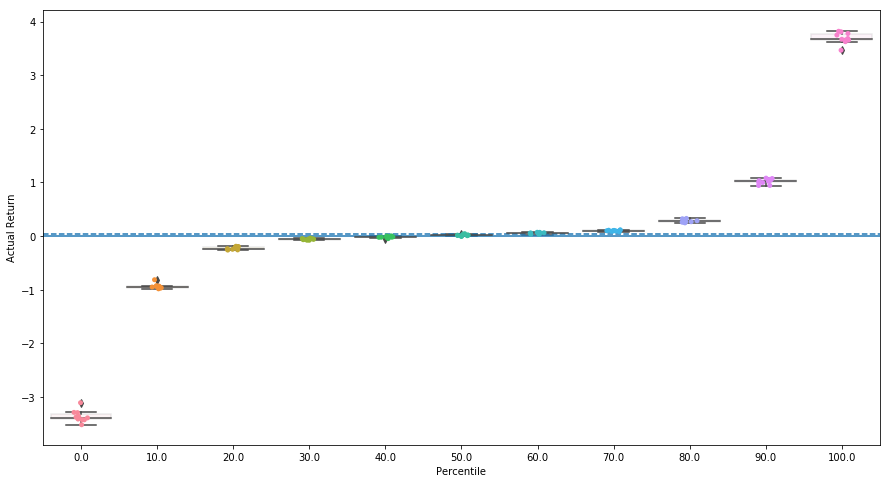

In [73]:
plt.figure(figsize=(15,8))
df_plot = results_t_col.reset_index()
ax = sns.stripplot(y=df_plot["Actual Return"], x=df_plot["Score_rd"])
ax = sns.boxplot(y=df_plot["Actual Return"], x=df_plot["Score_rd"], boxprops=dict(alpha=.1))
ax.axhline(np.mean(df_combined.rtn), ls='--')
ax.axhline(0, ls='-')
ax.set(xlabel='Percentile')

In [74]:
len(model2.feature_importance(importance_type = 'gain'))

403

In [94]:
results_v_col.loc[100.0]

,Prediction,Actual Return,BuySignal%,Score,UpRate
Score_rd,,,,,
100.0,0.376848,0.181286,0.494768,97.502990,0.467862
100.0,0.329877,0.103767,0.499253,97.500935,0.478326
100.0,0.333619,0.065479,0.525449,97.502995,0.440120
100.0,0.342622,0.262096,0.504491,97.502247,0.464072
100.0,0.325025,0.404581,0.504491,97.501498,0.508982
100.0,0.299742,0.274386,0.505988,97.500937,0.495509
100.0,0.322823,0.123548,0.476048,97.500375,0.467066
100.0,0.347067,0.215652,0.544228,97.503187,0.467766
100.0,0.350746,0.291934,0.490255,97.503561,0.494753


(-0.2, 0.2754726513232164)

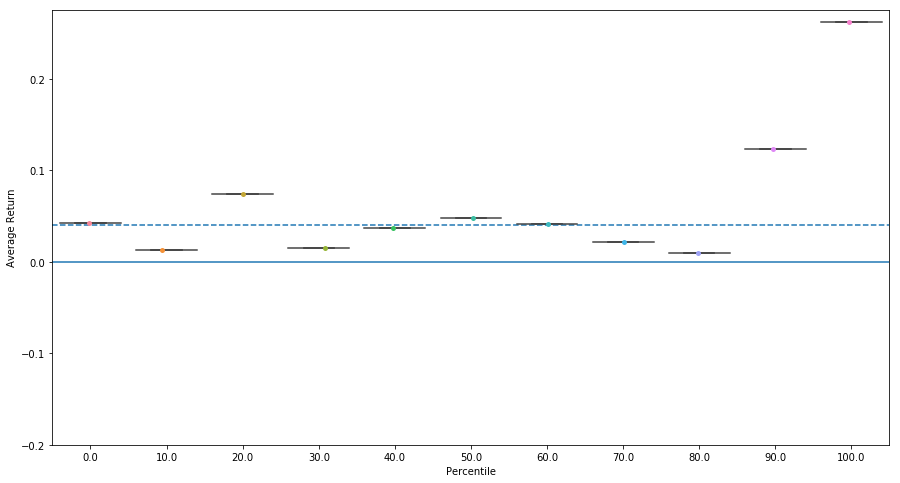

In [89]:
plt.figure(figsize=(15,8))
df_plot = results_v_col.reset_index().iloc[33:44,:]
ax = sns.stripplot(y=df_plot["Actual Return"], x=df_plot["Score_rd"])
ax = sns.boxplot(y=df_plot["Actual Return"], x=df_plot["Score_rd"], boxprops=dict(alpha=.1))
ax.axhline(np.mean(df_combined.rtn), ls='--')
ax.axhline(0, ls='-')
ax.set(xlabel='Percentile', ylabel='Average Return')
ax.set_ylim(-0.2,)

In [76]:
len(Feature_matrix_w_rtn.columns[1:])

403

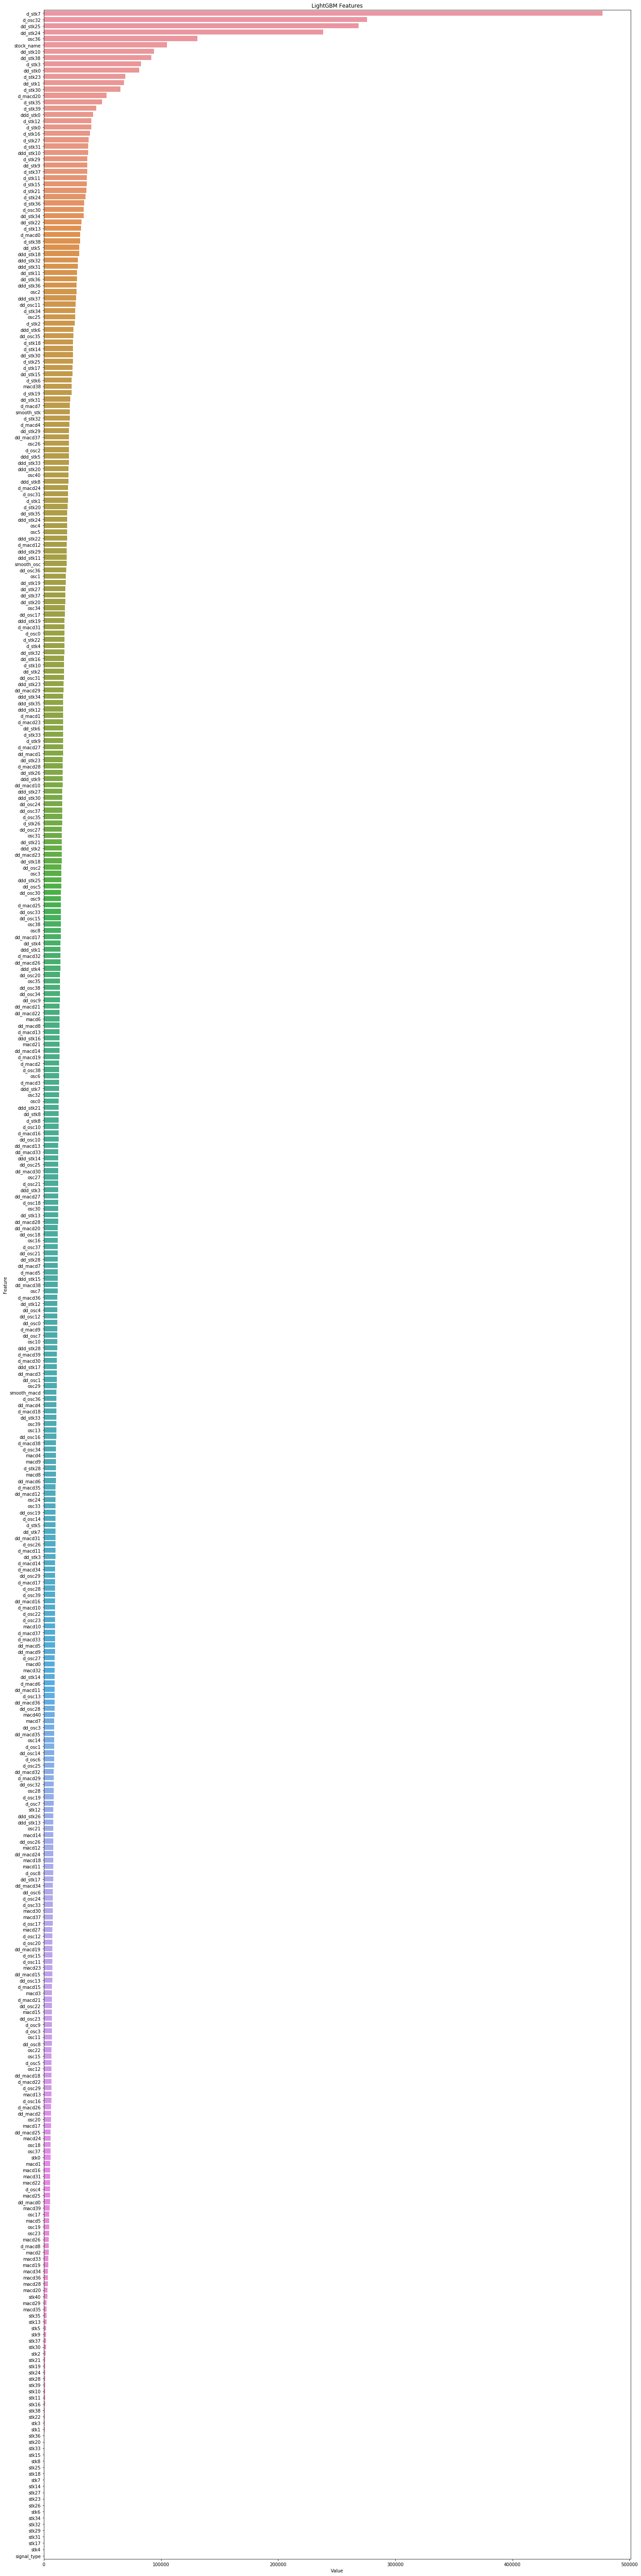

In [77]:
feature_imp = pd.DataFrame(sorted(zip(model2.feature_importance(importance_type = 'gain'),Feature_matrix_w_rtn.columns[1:])), columns=['Value','Feature'])

plt.figure(figsize=(20, 80))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()